# Energy System Modelling - Tutorial V.4

In [1159]:
import pypsa
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

Allow pypsa component link to have multiple out- and inputs (further information https://pypsa.org/doc/components.html#link-with-multiple-outputs-or-inputs)

In [1160]:
override_component_attrs = pypsa.descriptors.Dict({k : v.copy() for k,v in pypsa.components.component_attrs.items()})
override_component_attrs["Link"].loc["bus2"] = ["string",np.nan,np.nan,"2nd bus","Input (optional)"]
override_component_attrs["Link"].loc["bus3"] = ["string",np.nan,np.nan,"3rd bus","Input (optional)"]
override_component_attrs["Link"].loc["efficiency2"] = ["static or series","per unit",1.,"2nd bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["efficiency3"] = ["static or series","per unit",1.,"3rd bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["p2"] = ["series","MW",0.,"2nd bus output","Output"]
override_component_attrs["Link"].loc["p3"] = ["series","MW",0.,"3rd bus output","Output"]

Create a pypsa network with multi-links

In [1161]:
n = pypsa.Network(override_component_attrs=override_component_attrs)

set the snapshots


In [1162]:
n.set_snapshots(range(10))

add a bus and the corresponding load for the carriers transport, electricity

In [1163]:
# electrical bus + load (constant)
n.add("Bus",
      "electric")

n.add("Load",
      "electric",
      bus="electric",
      p_set=1.)

# transport bus + load (constant)
n.add("Bus",
      "transport")

n.add("Load",
      "transport",
      bus="transport",
      p_set=1.)


add a bus for hydrogen, gas, diesel and biomass and a corresponding store


In [1164]:
# hydrogen 
n.add("Bus",
      "hydrogen")

n.add("Store",
      "hydrogen",
      bus="hydrogen",
      e_nom=50.,
      e_initial=50)

# gas
n.add("Bus",
      "gas")

n.add("Store",
      "gas",
      e_initial=50,
      e_nom=50,
      marginal_cost=10.,
      bus="gas")

# diesel
n.add("Bus",
      "diesel")

n.add("Store",
      "diesel",
      bus="diesel",
      e_cyclic=True,
      e_nom=100.)

# # biomass
# n.add("Bus",
#       "biomass")

# n.add("Store",
#       "biomass",
#       bus="biomass",
#       marginal_cost=50., 
#       e_nom=40,
#       e_initial=40)


The CO2 can be stored (for example in underground cavern, see https://en.wikipedia.org/wiki/Carbon_capture_and_storage#Geological_storage). To model CO2 storage we have to keep track of the CO2
which is emitted to the atmosphere. Therefore we add a bus and a storage for the CO2 in the atmosphere 
and the stored CO2

In [1165]:
# minus sign because opposite to how fossil fuels used:
# CH4 burning puts CH4 down, atmosphere up
n.add("Carrier","co2",
      co2_emissions=-1.)

# this tracks CO2 in the atmosphere
n.add("Bus",
      "co2 atmosphere",
      carrier="co2")

n.add("Store",
      "co2 atmosphere",
      e_min_pu=-1,
      e_nom_extendable=True,
      bus="co2 atmosphere")

# this tracks CO2 stored, e.g. underground
n.add("Bus",
      "co2 stored")

n.add("Store","co2 stored",
      e_nom_extendable=True,
      e_min_pu=-1,
      capital_cost=5,
      bus="co2 stored")

Add the possibility of Direct Air Capture (DAC) (see https://en.wikipedia.org/wiki/Direct_air_capture) of CO2. It is captured from the atmosphere and stored.

In [1166]:
# Direct Air Capture (DAC)
n.add("Link",
      "DAC",
      bus0="co2 atmosphere",
      bus1="co2 stored",
      efficiency=1,
      marginal_cost=30,
      p_nom_extendable=True)

Add diesel cars to satisfy the transport demand using a multi-link

In [1167]:
# diesel car
n.add("Link",
      "diesel car",
      bus0="diesel",
      bus1="transport",
      bus2="co2 atmosphere",
      efficiency=1.,
      efficiency2=1.,
      p_nom=2.)

Add a open-cyclce gas turbine (OCGT) and biomass to satisfy the electricity demand

In [1168]:
# OCGT
n.add("Link",
      "OCGT",
      bus0="gas",
      bus1="electric",
      bus2="co2 atmosphere",
      p_nom_extendable=True,
      efficiency=0.5,
      efficiency2=1)

# biomass
# n.add("Link",
#       "biomass",
#       bus0="biomass",
#       bus1="electric",
#       p_nom_extendable=True,
#       efficiency=0.5)

Add electrolysis to convert hydrogen to electricity

In [1169]:
#n.add("Link",
 #     "electrolysis",
 #     p_nom=2.,
 #     efficiency=0.8,
 #     bus0="electric",
 #     bus1="hydrogen")

Diesel can be produced from H2 and CO2 via Fischer-Tropsch (see https://en.wikipedia.org/wiki/Fischer%E2%80%93Tropsch_process)
Add a link which represents this process

In [1170]:
n.add("Link",
      "Fischer-Tropsch",
      p_nom=4,
      bus0="hydrogen",
      bus1="diesel",
      bus2="co2 stored",
      efficiency=1.,
      efficiency2=-1)

Now we can set an upper limit for the CO2 emissions and add this limit as an additional constraint to the 
optimisation problem

In [1171]:
limit = 0
n.add("GlobalConstraint",
      "co2_limit",
      sense="<=",
      carrier_attribute="co2_emissions",
      constant=limit)

Solve the optimisation problem

In [1172]:
n.lopf()

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1200.0
  Upper bound: 1200.0
  Number of objectives: 1
  Number of constraints: 242
  Number of variables: 145
  Number of nonzeros: 488
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.0203249454498291
# ----------------------------------------------------------
#   Solution Information
# ------------------------------

('ok', 'optimal')

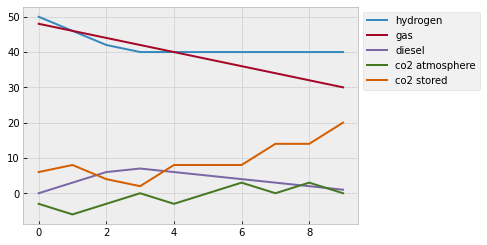

In [1173]:
n.stores_t.e.plot().legend(bbox_to_anchor=(1,1))

In [1174]:
n.objective, n.global_constraints.mu

(1200.0,
 co2_limit    35.0
 Name: mu, dtype: float64)

In [1175]:
n.links.p_nom_opt

DAC                6.0
diesel car         2.0
OCGT               2.0
Fischer-Tropsch    4.0
Name: p_nom_opt, dtype: float64

Show that at every time step the amount of carbon in the whole system is constant

In [1176]:
n.stores_t.e[["co2 stored","co2 atmosphere","gas","diesel"]].sum(axis=1)

0    51.0
1    51.0
2    51.0
3    51.0
4    51.0
5    51.0
6    51.0
7    51.0
8    51.0
9    51.0
dtype: float64

In [1177]:
n.stores.e_nom_opt

hydrogen           50.0
gas                50.0
diesel            100.0
co2 atmosphere      6.0
co2 stored         20.0
Name: e_nom_opt, dtype: float64

How does the result change when we add Carbon Capture and Storage (CCS) for biomass and OCGT?

In [1178]:
# OCGT + Carbon Capture and Storage (CCS)
n.add("Link","OCGT+CCS",
      bus0 = "gas",
      bus1 = "electric",
      bus2 = "co2 stored",
      bus3 = "co2 atmosphere",
      p_nom_extendable=True,
      marginal_cost=8.50,
      efficiency = 0.4,
      efficiency2 = 0.9,
      efficiency3 = 0.1)

# # biomass + Carbon Capture and Storage (CCS)
# n.add("Link","biomass+CCS",
#       bus0 = "biomass",
#       bus1 = "electric",
#       bus2 = "co2 stored",
#       bus3 = "co2 atmosphere",
#       p_nom_extendable=True,
#       efficiency = 0.4,
#       efficiency2 = 1.,
#       efficiency3 = -1)

And solve the network again:

In [1179]:
n.lopf()


INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 962.5
  Upper bound: 962.5
  Number of objectives: 1
  Number of constraints: 262
  Number of variables: 156
  Number of nonzeros: 558
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.021686792373657227
# ----------------------------------------------------------
#   Solution Information
# ------------------------------

('ok', 'optimal')

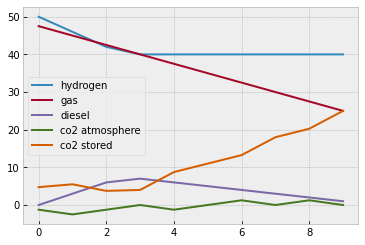

In [1180]:
n.stores_t.e.plot()

In [1181]:
n.global_constraints.mu, n.objective

(co2_limit    35.0
 Name: mu, dtype: float64,
 962.5)

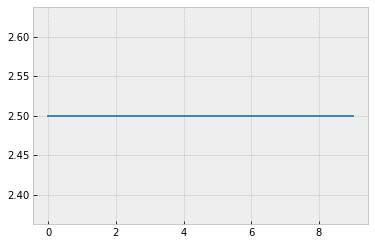

In [1182]:
n.links_t.p0.loc[:, "OCGT+CCS"].plot()

In [1183]:
n.links


attribute,bus0,bus1,type,efficiency,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_set,p_min_pu,p_max_pu,capital_cost,marginal_cost,length,terrain_factor,p_nom_opt,bus2,bus3,efficiency2,efficiency3
DAC,co2 atmosphere,co2 stored,,1.0,0.0,True,0.0,inf,0.0,0.0,1.0,0.0,30.0,0.0,1.0,2.5,,,1.0,1.0
diesel car,diesel,transport,,1.0,2.0,False,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,co2 atmosphere,,1.0,1.0
OCGT,gas,electric,,0.5,0.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,co2 atmosphere,,1.0,1.0
Fischer-Tropsch,hydrogen,diesel,,1.0,4.0,False,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,co2 stored,,-1.0,1.0
OCGT+CCS,gas,electric,,0.4,0.0,True,0.0,inf,0.0,0.0,1.0,0.0,8.5,0.0,1.0,2.5,co2 stored,co2 atmosphere,0.9,0.1


In [1184]:
n.stores.e_nom_opt

hydrogen           50.0
gas                50.0
diesel            100.0
co2 atmosphere      2.5
co2 stored         25.0
Name: e_nom_opt, dtype: float64

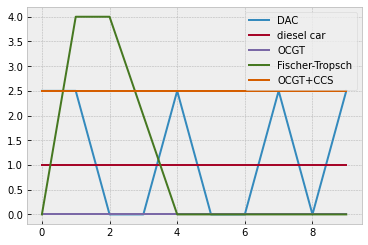

In [1187]:
n.links_t.p0.plot()

In [1188]:
n.links_t.p0


,DAC,diesel car,OCGT,Fischer-Tropsch,OCGT+CCS
0,2.5,1.0,0.0,0.0,2.5
1,2.5,1.0,0.0,4.0,2.5
2,0.0,1.0,0.0,4.0,2.5
3,0.0,1.0,0.0,2.0,2.5
4,2.5,1.0,0.0,0.0,2.5
5,0.0,1.0,0.0,0.0,2.5
6,0.0,1.0,0.0,0.0,2.5
7,2.5,1.0,0.0,0.0,2.5
8,0.0,1.0,0.0,0.0,2.5
9,2.5,1.0,0.0,0.0,2.5


In [1189]:
n.links.p_nom_opt

DAC                2.5
diesel car         2.0
OCGT               0.0
Fischer-Tropsch    4.0
OCGT+CCS           2.5
Name: p_nom_opt, dtype: float64

In [1193]:
n.global_constraints.constant = -50

In [1194]:
n.lopf()

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2712.5
  Upper bound: 2712.5
  Number of objectives: 1
  Number of constraints: 262
  Number of variables: 156
  Number of nonzeros: 558
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.04013490676879883
# ----------------------------------------------------------
#   Solution Information
# -----------------------------

('ok', 'optimal')

In [1195]:
n.links.p_nom_opt


DAC                12.5
diesel car          2.0
OCGT                0.0
Fischer-Tropsch     4.0
OCGT+CCS            2.5
Name: p_nom_opt, dtype: float64

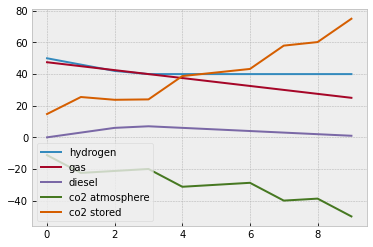

In [1196]:
n.stores_t.e.plot()